In [64]:
import pandas as pd
from datasets import Dataset

df = pd.read_json('detection_dataset_1st_iter.jsonl', lines=True)
dataset = Dataset.from_pandas(df)

In [65]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [67]:
import numpy as np
import evaluate
from sklearn.metrics import fbeta_score

accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")
roc_auc = evaluate.load("roc_auc")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision.compute(predictions=predictions, references=labels, average='weighted')["precision"],
        "recall": recall.compute(predictions=predictions, references=labels, average='weighted')["recall"],
        "f1": f1.compute(predictions=predictions, references=labels, average='weighted')["f1"],
        "f2": fbeta_score(labels, predictions, beta=2, average="weighted")
    }

In [ ]:
from transformers import AutoModelForSequenceClassification

id2label = {0: "REAL", 1: "GENERATED"}
label2id = {"REAL": 0, "GENERATED": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_data = dataset.map(preprocess_function, batched=True)
tokenized_data = tokenized_data.train_test_split(test_size=0.2, seed=42)
training_eval_tokenized_data = tokenized_data['train'].train_test_split(test_size=0.1, seed=42)

Map:   0%|          | 0/1092 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer

trainer = Trainer(
    model=model,
    train_dataset=training_eval_tokenized_data['train'],
    eval_dataset=training_eval_tokenized_data['test'],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    args=TrainingArguments(
        output_dir="results_distilbert",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        weight_decay=0.01,
        logging_steps=10,
        eval_steps=10,
        eval_strategy="steps",
        load_best_model_at_end=True,
        report_to="none"
    ),
)

trainer.train()

finetuned_model = "distilbert-finetuned"
model.save_pretrained(finetuned_model)
tokenizer.save_pretrained(finetuned_model)

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F2
10,0.673000,0.641832,0.727273,0.827972,0.727273,0.711394,0.708172
20,0.631500,0.553000,0.840909,0.881405,0.840909,0.838589,0.834881
30,0.497500,0.417147,0.920455,0.920549,0.920455,0.920382,0.920397
40,0.365100,0.277424,0.954545,0.955626,0.954545,0.954593,0.954446
50,0.244200,0.202709,0.954545,0.954545,0.954545,0.954545,0.954545
60,0.190900,0.135761,0.977273,0.978330,0.977273,0.977296,0.977161
70,0.110700,0.105981,0.988636,0.988873,0.988636,0.988626,0.988601
80,0.095200,0.073587,0.988636,0.988907,0.988636,0.988644,0.988609
90,0.072500,0.065671,1.000000,1.000000,1.000000,1.000000,1.000000
100,0.056600,0.060584,1.000000,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=100, training_loss=0.29372166633605956, metrics={'train_runtime': 1851.5374, 'train_samples_per_second': 0.848, 'train_steps_per_second': 0.054, 'total_flos': 56214558677700.0, 'train_loss': 0.29372166633605956, 'epoch': 2.0})

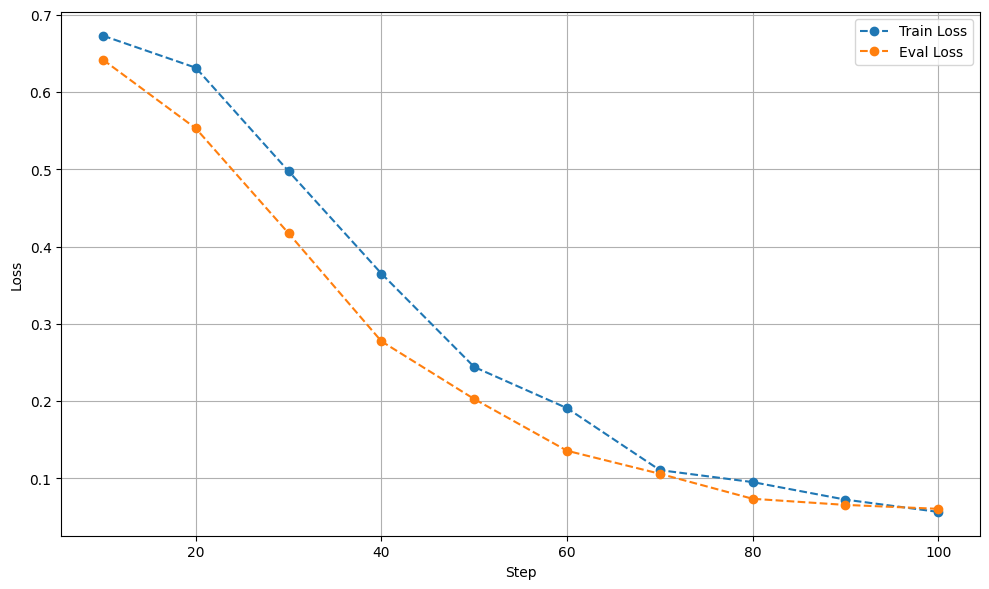

In [73]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_steps = [log["step"] for log in logs if "loss" in log and "eval_loss" not in log]
train_losses = [log["loss"] for log in logs if "loss" in log and "eval_loss" not in log]

eval_steps = [log["step"] for log in logs if "eval_loss" in log]
eval_losses = [log["eval_loss"] for log in logs if "eval_loss" in log]

plt.figure(figsize=(10,6))
plt.plot(train_steps, train_losses, label="Train Loss", marker='o', linestyle='--')
plt.plot(eval_steps, eval_losses, label="Eval Loss", marker='o', linestyle='--')

plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("detector_train_eval_loss.svg")
plt.show()

Metrics: {'accuracy': 0.9817351598173516, 'precision': 0.9819096695136894, 'recall': 0.9817351598173516, 'f1': 0.9817404968469592, 'f2': 0.9817176171844826}


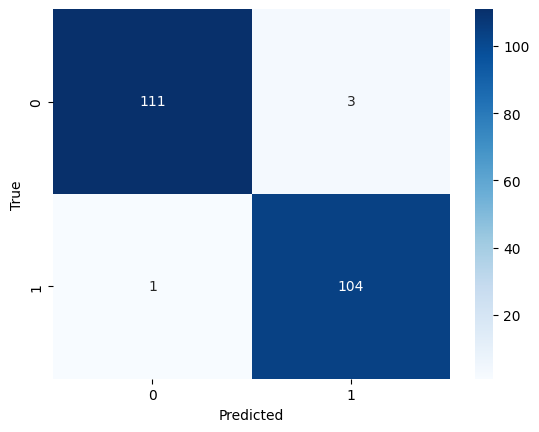

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = evaluate.load("confusion_matrix")

pred_output = trainer.predict(tokenized_data["test"])
predictions = pred_output.predictions
labels = pred_output.label_ids

print("Metrics:", compute_metrics((predictions, labels)))

results = conf_matrix.compute(predictions=np.argmax(predictions, axis=1), references=labels)
cm = np.array(results["confusion_matrix"])

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix.svg")
plt.show()

In [75]:
idx = 0

text = tokenized_data["test"][idx]["text"]
print(text)

example = tokenized_data["test"].select([idx])
prediction = trainer.predict(example)

predicted_label = np.argmax(prediction.predictions, axis=1)[0]
true_label = tokenized_data["test"][idx]["label"]
label_map = {0: "REAL", 1: "GENERATED"}
print(f"Predicted: {label_map[predicted_label]} vs. True: {label_map[true_label]}")

Adobe Photoshop CC 2019 versions 20.0.8 and earlier, and Photoshop 2020 versions 21.1 and earlier have a memory corruption vulnerability. Successful exploitation could lead to arbitrary code execution


Predicted: REAL vs. True: REAL
